<a href="https://colab.research.google.com/github/NadaAdelMousa/NLP_Tweets_Hate_Speech/blob/main/Lab_2_Text_Classification_using_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**The same task as Lab 1 except using `Word Embeddings OR RNNs`**

**Watch out!<br>
Preproceesing here is a a bit different<br>
Just take the cleaned data from the previous lab and cont...**


**Dataset**
labeled datasset collected from twitter

**Objective**
classify tweets containing hate speech from other tweets.
0 -> no hate speech
1 -> contains hate speech

**Total Estimated Time = 60 Mins**

### Import Libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Load Dataset

In [2]:
!gdown https://drive.google.com/uc?id=1BNcVdg2ByP1yvEL8UOeXeFHvAgyowjC1 -O dataset.csv

Downloading...
From: https://drive.google.com/uc?id=1BNcVdg2ByP1yvEL8UOeXeFHvAgyowjC1
To: /content/dataset.csv
100% 2.33M/2.33M [00:00<00:00, 176MB/s]


In [60]:
df = pd.read_csv('dataset.csv')
df.head()

,Unnamed: 0,tweets,label
0,0,when a father be dysfunctional and be so selfi...,0.0
1,1,thank for lyft credit i cant use cause they do...,0.0
2,2,bihday your majesty,0.0
3,3,model i love u take with u all the time in ur,0.0
4,4,factsguide society now motivation,0.0


In [61]:
train_text = df['tweets'].values.astype('str')
labels = df['label'].values.astype('float32')

In [62]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = \
     train_test_split(train_text, labels, test_size=.2, stratify=labels, random_state=42)

In [63]:
print(len(x_train))
print(len(x_val))

23624
5906


### Preprocessing


In [64]:
from keras.preprocessing.text import Tokenizer
vocab_sz = 10000
tok = Tokenizer(num_words=vocab_sz, oov_token='UNK')
tok.fit_on_texts(x_train)

In [65]:
x_train_tok = tok.texts_to_sequences(x_train)
x_val_tok = tok.texts_to_sequences(x_val)

In [66]:
print(x_train_tok[0])
print(y_train[0])

[33, 530, 214, 460, 10, 49, 20, 878, 766, 18, 2, 175, 1259, 3512, 5]
0.0


### Modelling
**Use any Advanced technique such as: word2vec, glove, RNNs ... etc**

In [67]:
tweet_len = np.zeros(len(x_train_tok))
for v in range(len(x_train_tok)):
    tweet_len[v] = len(x_train_tok[v])

(array([1566., 3340., 4695., 4940., 3676., 3475., 1316.,  500.,  109.,
           7.]),
 array([ 1. ,  4.2,  7.4, 10.6, 13.8, 17. , 20.2, 23.4, 26.6, 29.8, 33. ]),
 <a list of 10 Patch objects>)

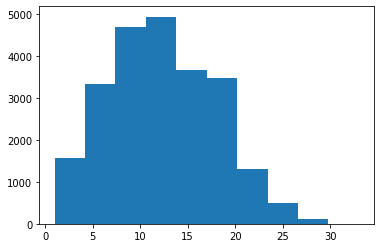

In [68]:
plt.hist(tweet_len)

In [74]:
from tensorflow.keras.preprocessing import sequence
x_train_emb = sequence.pad_sequences(x_train_tok, maxlen=30, padding='post')
x_val_emb = sequence.pad_sequences(x_val_tok, maxlen=30, padding='post')

In [76]:
x_train_emb[0]

array([  33,  530,  214,  460,   10,   49,   20,  878,  766,   18,    2,
        175, 1259, 3512,    5,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0], dtype=int32)

In [77]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding
from tensorflow.keras.layers import LSTM, Bidirectional, GRU, Dropout

model = Sequential()
model.add(Embedding(vocab_sz, 128, mask_zero=True))
model.add(Bidirectional(LSTM(100)))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 128)         1280000   
                                                                 
 bidirectional_2 (Bidirectio  (None, 200)              183200    
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 1)                 201       
                                                                 
Total params: 1,463,401
Trainable params: 1,463,401
Non-trainable params: 0
_________________________________________________________________


In [78]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['acc'])

In [85]:
from keras.callbacks import EarlyStopping

checkpoint = EarlyStopping(monitor='val_acc', mode='max')
callbacks_lst = [checkpoint]

history = model.fit(x_train_emb, y_train,
          batch_size=32,
          epochs=10,
          validation_data=(x_val_emb, y_val),
          callbacks=callbacks_lst)

Epoch 1/10
739/739 [==============================] - 68s 93ms/step - loss: 0.0032 - acc: 0.9991 - val_loss: 0.2869 - val_acc: 0.9577
Epoch 2/10
739/739 [==============================] - 66s 89ms/step - loss: 0.0019 - acc: 0.9995 - val_loss: 0.2812 - val_acc: 0.9600


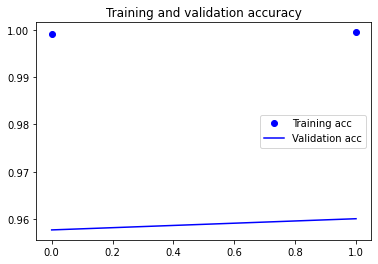

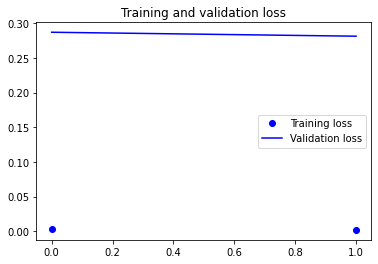

In [86]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

#### Evaluation

In [87]:
y_pred = model.predict(x_val_emb)
y_pred[y_pred <= 0.5] = 0
y_pred[y_pred > 0.5] = 1

In [88]:
from sklearn.metrics import classification_report
print(classification_report(y_pred,y_val))

              precision    recall  f1-score   support

         0.0       0.98      0.97      0.98      5567
         1.0       0.63      0.75      0.68       339

    accuracy                           0.96      5906
   macro avg       0.81      0.86      0.83      5906
weighted avg       0.96      0.96      0.96      5906



#### Done!